In [57]:
%reset

# import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, hanning
import scipy
from scipy.io import loadmat
import os
import pandas as pd
import datetime as dt
import collections

# import constants
c = 2.998e8 # m/s 

Import sample data from VLF Rx on Table Mtn

In [58]:
# import input data from VLF rx on table mtn
datadir = 'vlf_data'
datafiles = [f for f in os.listdir(datadir) if os.path.isfile(os.path.join(datadir, f))]

# x data is the 000.mat file 
for dfile in datafiles:
    if dfile[-5] == '0':
        bx_datafile = os.path.join(datadir, dfile)
    else:
        by_datafile = os.path.join(datadir, dfile)

# load mat files
bx_data = loadmat(bx_datafile)
by_data = loadmat(by_datafile)

# grab start time
data_start = dt.datetime(int(bx_data['start_year']), int(bx_data['start_month']), 
int(bx_data['start_day']), int(bx_data['start_hour']), int(bx_data['start_minute']), 
int(bx_data['start_second']))

# define param of input data
fs_vlf = 100e3
n_samples = 100e3 # user defined
data_len_vlf = n_samples / fs_vlf

bx_data = np.squeeze(bx_data['data'][:int(n_samples)])
by_data = np.squeeze(by_data['data'][:int(n_samples)])

In [64]:
# create a timevec for the data at current sample rate
data_dt_vlf = dt.timedelta(microseconds=1e6/fs_vlf) # convert time delta to datetime obj.
time_vec_vlf = [data_start+(data_dt_vlf*i) for i in range(int(n_samples))] # create time vec

# create a timevec for the data at desired sampling freq.
fs = 2**17
data_dt = dt.timedelta(microseconds=1e6/fs) # convert time delta to datetime obj. - NOT WORKING roundoff error
time_vec = [data_start+(data_dt*i) for i in range(int(fs * n_samples / fs_vlf))] # create time vec

# interpolate w a linear func 
t_vlf = np.linspace(0, len(time_vec_vlf), num=len(time_vec_vlf), endpoint=True)
t_fs = np.linspace(0, len(time_vec_vlf), num=len(time_vec), endpoint=True)

f_x = scipy.interpolate.interp1d(t_vlf, bx_data)
f_y = scipy.interpolate.interp1d(t_vlf, by_data)

bx_a = f_x(t_fs)
by_a = f_y(t_fs)

bx = np.array(bx)
by = np.array(by)

channels_td = [bx, by] 

# convert each channel of time series data to 16 bit (signed) integer
for ci, c in enumerate(channels_td):
    channels_td[ci] = np.int16(c)

# check input stimulus here 

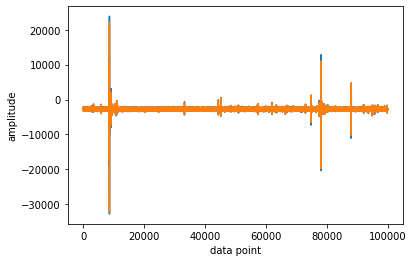

In [65]:
# check the resampled data
plt.plot(t_vlf, bx_data, '-', t_fs, bx, '-')
plt.xlabel('data point')
plt.ylabel('amplitude')
plt.show()

Or, create a test signal here  -- start with time series data

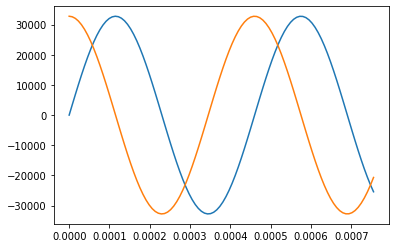

In [30]:
# create time domain data
fs = 2**17                              # sampling freq. 
sample_len = 2                          # seconds
t_vec = np.arange(0, sample_len, 1/fs)  # create time vec
signal_freq = 2.173e3                   # signal freq.
amp = 2**15 -1                          # signal amplitude

# channels (ex, ey, bx, by, bz)
shift = np.pi/2  # shift between 2 channels                       

bx = amp * np.sin(signal_freq * 2 * np.pi * t_vec)
by = amp * np.sin(signal_freq * 2 * np.pi * t_vec + shift)

 # collect time domain channels here
channels_td = [bx, by]                

# plot a small chunk of time series data
plt.plot(t_vec[:100], bx[:100])
plt.plot(t_vec[:100], by[:100])
plt.show()
plt.close()

# convert each channel of time series data to 16 bit (signed) integer
for ci, c in enumerate(channels_td):
    channels_td[ci] = np.int16(c)

Next, hanning window

In [66]:
# gen. hanning window coefs
nFFT = 1024

# NEED TO CHECK THIS
win = (2**32-1) * hanning(nFFT)

Next, break time series data into chunks of 512 length (1024 / 2, bc it's easier to shift)

In [67]:
# segmented time domain data
channels_td_segmented = []

# go through each channel
for c in channels_td: 
    
    # store each segmented channel
    c_segs = []  

    # loop through channel td data by 512
    for i in range(0, len(c), int(nFFT/2)): 

        # grab a segment
        cs = c[i:i+int(nFFT/2)] 

        # add 0s to segment that isn't 512 points
        while len(cs) < int(nFFT/2): 
            cs = np.append(cs, 0)

        # append each segment to segmented channel list
        c_segs.append(cs) 

    # all channels now segmented and stored here
    channels_td_segmented.append(c_segs)


Take FFT on input * window function for every 1024 points shifting by 512

**HOW DO WE HANDLE FIRST AND LAST WINDOW?**

In [68]:
# loop through all 512-length-segments -- this step accounts for the 50% overlap
channels_fd = [] # store channels now in frequency domain

for c in channels_td_segmented:
    c_fd = [] # store each segment of channel f domain

    # go through all 512-length segments
    for i in range(len(c)):
        if i == len(c)-1: # check if last segment
            break

        # grab current segment and next one -- THIS STEP COMBINES TWO 512-length into 1024 
        cs_2 = np.append(c[i], c[i+1]) 

        # mutitply elementwise by windowing func
        cs_win = np.multiply(win, cs_2) 

        # take FFT
        cs_f = np.fft.fft(cs_win)
        
        # save it
        c_fd.append(cs_f)

    # save the output for each channel - vector of 1024-pt FFTs
    channels_fd.append(c_fd)

power calculation -- here's where we break into spectra and cross spectra

In [70]:
# store spectra and xspectra
spectra = []
xspectra = []

# loop through the channels
xspec_done = []
for ci, c in enumerate(channels_fd): 

    # loop through the channels again
    for ci_x, c_x in enumerate(channels_fd): 

        # check if same channel or a diff one
        if ci == ci_x: 
            # same channel - real^2 + imag^2 = power of spectra term
            Ps = [np.real(fch)**2 + np.imag(fch)**2 for fch in c_x] 

            # save spectra power
            spectra.append(Ps)

        # different channel = x-spectra, but only need upper triangle
        if ci != ci_x and (ci, ci_x) not in xspec_done and (ci_x, ci) not in xspec_done: 
            # diff channel: R = real1*real2 + imag1*imag2 , I = real1*imag2 - real2*imag1
            Pxs_r = [np.real(np.real(fch) * np.real(fchx) + np.imag(fch) * np.imag(fchx)) for fchx, fch in zip(c_x, c)]
            Pxs_i = [np.real(fchx) * np.imag(fch) - np.real(fch) * np.imag(fchx) for fchx, fch in zip(c_x, c)]

            xspec_done.append((ci,ci_x))
            
            # save cross spectra power
            xspectra.append(Pxs_r)
            xspectra.append(Pxs_i)


Average in time (every second)

In [71]:
def time_avg(P): # input power array

    # add one more element??????
    P.append(np.zeros(nFFT))

    # scalar representing number of time points for one second
    accumulate_t = int(fs/(nFFT/2))

    # loop through each time point
    P_avg = []

    # for every chunk of time points
    for t in range(0, len(P), accumulate_t):
        
        # accumulate for one second and save it
        P_seg = P[t:accumulate_t+t]
        P_avg.append(sum(P_seg) / len(P_seg))

    return P_avg # returns vec that is i x j  in size where i = number of seconds and j = nFFT

# time average for each spectra and cross spectra
spectra_tavg = [time_avg(s) for s in spectra]
xspectra_tavg = [time_avg(xs) for xs in xspectra]

Rebin by averaging the correct bins into CANVAS fbins

In [72]:
# bin for CANVAS bins

# parse text file with canvas bins
fname = 'fbins.txt'                                 
fbins_str = np.genfromtxt(fname, dtype='str') 
fbins_dbl = [(float(f[0].replace(',','')),float(f[1].replace(',',''))) for f in fbins_str]

# monotonic and 1D list of canvas fbins
fbins = [item for sublist in fbins_dbl for item in sublist]

# find center freqs of bins from fft
center_freqs = np.fft.fftfreq(nFFT,d=1/fs) # seems like missing last bin, but doesn't matter bc we discard it

def rebin(P): # input power array that is x by y (x=numner of seconds, y=1024pt fft)
    # create an empty array to store rebinned power array
    rebinned_power = []

    # loop through each averaged second of the power array
    for p_sec in P:
        # save all rebinned freq for that time point
        rebinned_tp = [] 

        # loop through canvas bins
        for fbins_ind in range(0, len(fbins), 2):
            # current canvas bin
            current_bin = (fbins[fbins_ind], fbins[fbins_ind+1])

            # store power with freq inside the current canvas bin
            newbin_power = [] 

            # loop through fft bins and see if contained in current canvas bin
            for ff_ind, ff_val in enumerate(center_freqs):
                
                if ff_val >= current_bin[0] and ff_val < current_bin[1]:
                    # append power value to list for new canvas bin
                    newbin_power.append(p_sec[ff_ind])
            
            # add up the values contained in canvas bin and average
            rebinned_tp.append(sum(newbin_power)/len(newbin_power))

            # break at the last canvas bin
            if fbins_ind > len(fbins) - 4: 
                break

        # add final list of rebinned power for that time point
        rebinned_power.append(rebinned_tp)

    return rebinned_power # returned array will be size x by y (x=number of seconds, y=1024pt fft)

# rebin to get average for canvas fbins from the time averaged spectra and xspecrta
spectra_favg = [rebin(s) for s in spectra_tavg]
xspectra_favg = [rebin(xs) for xs in xspectra_tavg]

# final values - for x channels there should be x elements in spectra and 2*x in xspectra
spectra_final = spectra_favg
xspectra_final = xspectra_favg

Compression

In [73]:
# first, sqrt
spectra_sqrt = [np.sqrt(s) for s in spectra_final]
xspectra_sqrt = [np.sqrt(xs) for xs in xspectra_final]

# log 2 compression
spectra_compressed = [np.log2(sc) * 8 for sc in spectra_sqrt]
xspectra_compressed = [np.log2(xsc) * 8 for xsc in xspectra_sqrt]

Text(0.5, 0, 'time [s]')

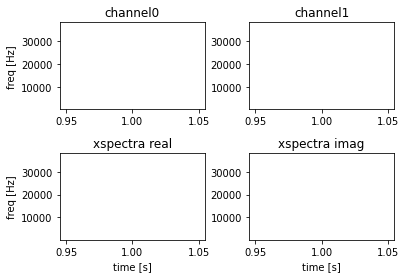

In [74]:
# plot a spectrogram
t_size = np.shape(spectra_final)[1] # second dimension is number of time points
tt = np.arange(1,t_size+1,1)          # create a time vector
ff = fbins[::2]

fig, axs = plt.subplots(len(xspectra), len(spectra)) # one column for each channel, 
plt.subplots_adjust(wspace=0.3,hspace=0.5)
for i, s in enumerate(spectra_sqrt):
    spectrogram_spec = np.array(s).T
    axs[0,i].pcolormesh(tt, ff, spectrogram_spec, cmap = plt.cm.jet)
    axs[0,i].set_title('channel'+ str(i))

for i, xs in enumerate(xspectra_sqrt):
    spectrogram_spec = np.array(xs).T
    axs[1,i].pcolormesh(tt, ff, spectrogram_spec, cmap = plt.cm.jet)
    
    if i%2==0:
        plt_str = 'real'
    else:
        plt_str = 'imag'

    axs[1,i].set_title('xspectra ' + plt_str)

# sest labels
axs[0,0].set_ylabel('freq [Hz]')
axs[1,0].set_ylabel('freq [Hz]')
axs[1,0].set_xlabel('time [s]')
axs[1,1].set_xlabel('time [s]')

In [ ]:
# Notes:

# NEVER use integer frequency -- strangeness in noise, no powers of 2, no even numbers, try closest prime number etc. 
# make sure frequency is NOT close to nyquist.
# 3/4 of full scale (too low is too close to noise, too high will give us saturation)
# test algorithm first with simple cases, then test corner cases (go through phase shifts, go through low and high)
# what happens at saturation from ADC 
# amp space, f space (make sure binning is correct), phase space 
# amp space will test compression

# time averaging - turn signals on and off, switch frequencies, stepping, drive signal for 1/8 second every second  - amplitude should be 
# ADC has intrinsic noise - 1 or 2 bits of bit noise, will average noise if time series data is not an int ofseconds 
# test different amplitues - effectively raises noise floor by factor of how many averaging 
# take log 2 steps
# or for each decade of parameter space (1,5,9 , 10,50,90 , 100, 500, 900 .....)
# output: take differences between spectrograms and look at residuals
# take slice in time vs output of algorithm (line plots...)
# quantify the difference 